In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import cv2
import json
import numpy as np
from copy_paste import CopyPaste
from coco import CocoDetectionCP
from visualize import display_instances
import albumentations as A
import random
from matplotlib import pyplot as plt

In [3]:
transform = A.Compose([
        A.RandomScale(scale_limit=(-0.9, 1), p=1), #LargeScaleJitter from scale of 0.1 to 2
        A.PadIfNeeded(256, 256, border_mode=0), #pads with image in the center, not the top left like the paper
        A.Flip(always_apply=True, p=0.5),
        A.Resize(800, 1333, always_apply=True, p=1),
        #A.Solarize(always_apply=True, p=1.0, threshold=(128, 128)),
        A.RandomCrop(534, 889),
        #A.Resize(800, 1333, always_apply=True, p=1),
        CopyPaste(blend=True, sigma=1, pct_objects_paste=1, p=1.) #pct_objects_paste is a guess
    ], bbox_params=A.BboxParams(format="coco")
)


In [4]:
transformScene = A.Compose([
        #A.RandomScale(scale_limit=(-0.9, 1), p=1), #LargeScaleJitter from scale of 0.1 to 2
        A.PadIfNeeded(256, 256, border_mode=0), #pads with image in the center, not the top left like the paper
        #A.Resize(800, 1333, always_apply=True, p=1),
        A.Resize(534, 889, always_apply=True, p=1),
        #A.RandomCrop(534, 889),
        #A.Resize(800, 1333, always_apply=True, p=1),
    ] 
    # bbox_params=A.BboxParams(format="coco", min_visibility=0.05)
)


In [5]:
data = CocoDetectionCP(
    '../Swin-Transformer-Object-Detection/data/flooding_high_cropped',
    # '../agilent-repos/mmdetection/data/bead_cropped_detection/images',
    #'../Swin-Transformer-Object-Detection/data/bead_cropped_detection/traintype2lower.json',
    '../Swin-Transformer-Object-Detection/data/beading_basler',
    '../Swin-Transformer-Object-Detection/data/basler_bead_non_cropped.json',
    transform,
    transformScene
)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


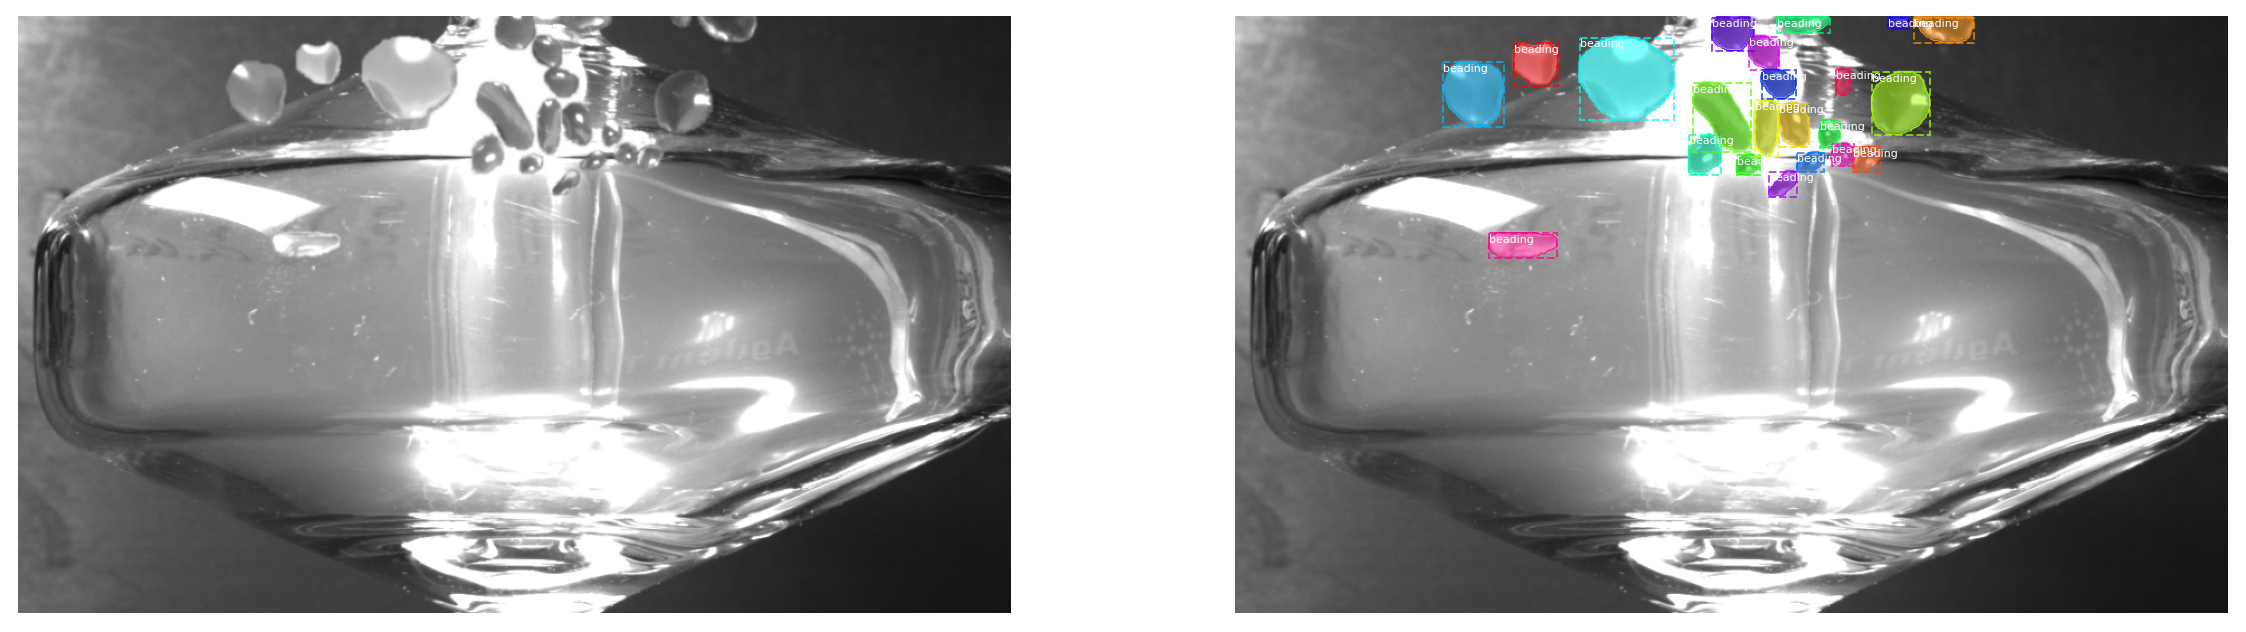

In [6]:
f, ax = plt.subplots(1, 2, figsize=(40, 40))

#index = random.randint(0, len(data))
#index = random.randint(0, 6) # We are testing on the 6 with annotations
index = 5  # hardcode for testing
img_data = data[index]
image = img_data['image']
masks = img_data['masks']
bboxes = img_data['bboxes']
new_anno = img_data['annotation']

with open('aug_one.json', 'w') as j_file:
    json.dump(new_anno, j_file, indent=4)

cv2.imwrite("Basler_acA2440-35um__23336827__20201014_102933834_103.tiff", image)

empty = np.array([])
display_instances(image, empty, empty, empty, empty, show_mask=False, show_bbox=False, ax=ax[0])

if len(bboxes) > 0:
    boxes = np.stack([b[:4] for b in bboxes], axis=0)
    box_classes = np.array([b[-2] for b in bboxes])
    mask_indices = np.array([b[-1] for b in bboxes])
    show_masks = np.stack(masks, axis=-1)[..., mask_indices]
    class_names = {k: data.c.coco.cats[k]['name'] for k in
                   data.c.coco.cats.keys()}
    display_instances(image, boxes, show_masks, box_classes, class_names, show_bbox=True, ax=ax[1])
else:
    display_instances(image, empty, empty, empty, empty, show_mask=False, show_bbox=False, ax=ax[1])